### calibrate tracks

In [1]:
import requests
import pandas as pd
from sqlalchemy import create_engine, MetaData, delete
import numpy as np
from scipy.stats import linregress as fit

import time
import pickle
import os
from tqdm import tqdm

from datetime import timedelta, datetime
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import utils
import warnings
warnings.filterwarnings('ignore') 

In [144]:
i = 21

locations = ['Sakhir', 'Jeddah', 'Melbourne', 'Baku', 'Miami', 'Monaco',
       'Barcelona', 'Montréal', 'Spielberg', 'Silverstone', 'Budapest',
       'Spa-Francorchamps', 'Zandvoort', 'Monza', 'Marina Bay', 'Suzuka',
       'Lusail', 'Austin', 'Mexico City', 'São Paulo', 'Las Vegas',
       'Yas Island']
location = locations[i]
print(location)
year = 2023

Yas Island


In [145]:
session = utils.get_session(location, year)
display(session)

if "Practice 1" in session.session_name.tolist():
    session_key_fp1 = session.query(" session_name == 'Practice 1'").session_key.iloc[0]
else:
    session_key_fp1 = session.query(" session_name == 'Qualifying'").session_key.iloc[0]
if "Practice 2" in session.session_name.tolist():
    session_key_fp2 = session.query(" session_name == 'Practice 2'").session_key.iloc[0]
else:
    session_key_fp2 = session.query(" session_name == 'Sprint'").session_key.iloc[0]

session_key_race = session.query(" session_name == 'Race'").session_key.iloc[0]
race_start_time = pd.to_datetime(session.query(" session_name == 'Race'").date_start.iloc[0])
race_end_time = pd.to_datetime(session.query(" session_name == 'Race'").date_end.iloc[0])

driver_config = {row['name_acronym']:row['driver_number'] for ind, row in utils.get_data(f'https://api.openf1.org/v1/drivers?session_key={session_key_race}').iterrows()}
driver_config_reverse = {v: k for k, v in driver_config.items()}


lap_data = pd.concat([utils.get_data(f'''https://api.openf1.org/v1/laps?session_key={session_key_fp1}'''), utils.get_data(f'''https://api.openf1.org/v1/laps?session_key={session_key_fp2}''')]).dropna(subset =['lap_duration'])
lap_data['date_start'] = pd.to_datetime(lap_data['date_start'],format="ISO8601")
lap_data['date_end'] = lap_data.apply(lambda x: x.date_start + timedelta(seconds = x.lap_duration), axis = 1)

ref_lap_distances = pd.DataFrame()
full_laps = pd.DataFrame()

LAP_THRESHOLDS = 50

print("Building model...")
for _, lap in tqdm(lap_data.sort_values(by = 'lap_duration').iloc[:LAP_THRESHOLDS].iterrows()):

    driver_number = lap.driver_number
    start_time = lap.date_start
    end_time = lap.date_end
    session_key = lap.session_key
    meeting_key = lap.meeting_key
    lap_duration = (end_time - start_time).total_seconds()

    config = {'start_time' : start_time - timedelta(seconds = 2), 'end_time' : start_time + timedelta(seconds = 2), 'session_key' : session_key, 'driver_number' : driver_number}
    car_data, location_data = utils.get_data_channels(config)

    car_data.loc[len(car_data)] = [driver_number, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, start_time, session_key, meeting_key]
    location_data.loc[len(location_data)] = [np.nan, np.nan, np.nan, driver_number, start_time, session_key, meeting_key]

    merged = utils.merge_data_channels(car_data.sort_values(by = 'date'), location_data.sort_values(by = 'date'))
    merged = utils.compute_distance(merged, start_time)
    ref_lap_distances = pd.concat([ref_lap_distances, merged[merged.date == start_time][['x','y','distance', 'driver_number']]])

    config = {'start_time' : start_time, 'end_time' : end_time, 'session_key' : session_key, 'driver_number' : driver_number}
    car_data, location_data = utils.get_data_channels(config)
    merged = utils.merge_data_channels(car_data.sort_values(by = 'date'), location_data.sort_values(by = 'date'))
    merged = utils.compute_distance(merged, start_time)
    full_laps = pd.concat([full_laps, merged[['x','y','distance', 'driver_number']]])

ref_lap_distances.dropna(inplace = True)
full_laps.dropna(inplace = True)



,location,country_key,country_code,country_name,circuit_key,circuit_short_name,session_type,session_name,date_start,date_end,gmt_offset,session_key,meeting_key,year
0,Yas Island,21,UAE,United Arab Emirates,70,Yas Marina Circuit,Practice,Practice 1,2023-11-24T09:30:00,2023-11-24T10:30:00,04:00:00,9190,1226,2023
1,Yas Island,21,UAE,United Arab Emirates,70,Yas Marina Circuit,Practice,Practice 2,2023-11-24T13:00:00,2023-11-24T14:00:00,04:00:00,9191,1226,2023
2,Yas Island,21,UAE,United Arab Emirates,70,Yas Marina Circuit,Practice,Practice 3,2023-11-25T10:30:00,2023-11-25T11:30:00,04:00:00,9192,1226,2023
3,Yas Island,21,UAE,United Arab Emirates,70,Yas Marina Circuit,Qualifying,Qualifying,2023-11-25T14:00:00,2023-11-25T15:00:00,04:00:00,9193,1226,2023
4,Yas Island,21,UAE,United Arab Emirates,70,Yas Marina Circuit,Race,Race,2023-11-26T13:00:00,2023-11-26T15:00:00,04:00:00,9197,1226,2023


Building model...


29it [01:35,  3.28s/it]


KeyError: 'date'

In [146]:
ref_lap_distances['mse'] = 0
ref_lap_distances.reset_index(inplace = True)
# ref_lap_distances

for index, row in ref_lap_distances.iterrows():
  ref_points = [[row.x, row.y]]
  mse = mean_squared_error(ref_lap_distances[['x', 'y']], np.repeat(ref_points, len(ref_lap_distances), 0))
  ref_lap_distances.mse.loc[index] = mse
  # print(index, mse)
  # break

start_line = ref_lap_distances.iloc[ref_lap_distances.mse.argmin()].x.round(3), ref_lap_distances.iloc[ref_lap_distances.mse.argmin()].y.round(3)
print(start_line)

(677.277, 2094.368)


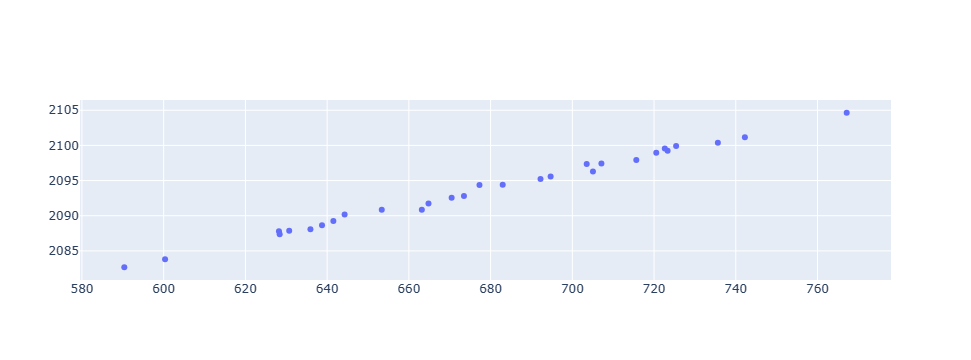

In [147]:
data = ref_lap_distances.iloc[:]

fig = go.Figure()
fig.add_trace(go.Scatter(x = data.x, y = data.y, mode = 'markers'))
fig.show()

(677.277, 2094.368)


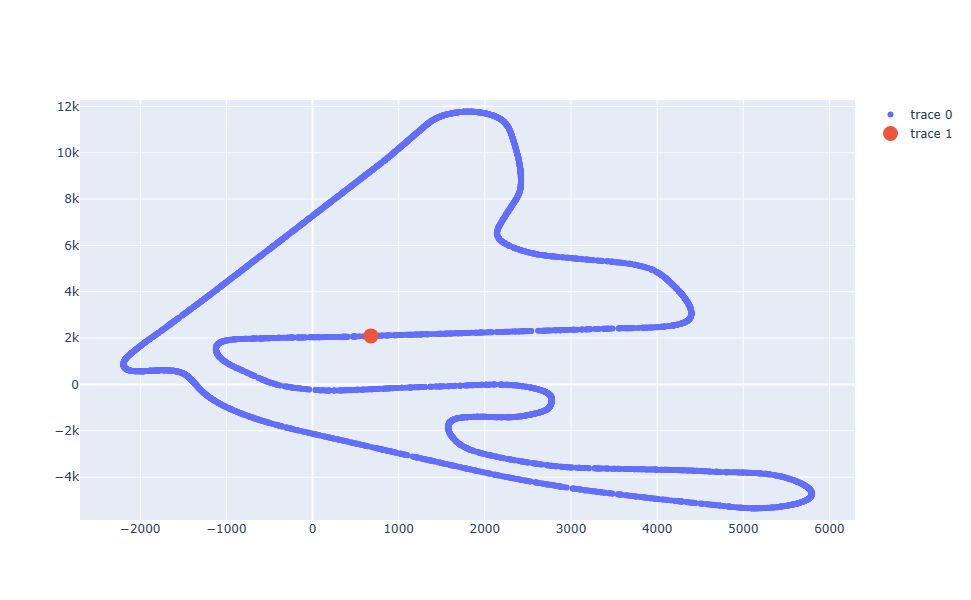

In [149]:
print(start_line)

data = full_laps.iloc[:5000]

yrange = [data.y.min()-500,data.y.max()+500]
xrange = [data.x.min()-500,data.x.max()+500]

if ((yrange[1] - yrange[0])/(xrange[1] - xrange[0])) > 1:
    height = 600
    width = int(600*(yrange[1] - yrange[0])/(xrange[1] - xrange[0]))
    
else:
    width = 600
    height = int(600*(yrange[1] - yrange[0])/(xrange[1] - xrange[0]))

fig = go.Figure()
fig.add_trace(go.Scatter(x = data.x, y = data.y, mode = 'markers'))
fig.add_trace(go.Scatter(x = [start_line[0]], y = [start_line[1]], mode = 'markers', marker = {'size':15}))
fig.update_layout(width = width, height = height, yaxis_range = yrange, xaxis_range = xrange)
fig.show()

In [150]:
before_start_line = (15, 2036)
after_start_line = (3000, 2357)

print(start_line, before_start_line, after_start_line)

(677.277, 2094.368) (15, 2036) (3000, 2357)


### Historical

In [8]:
import requests
import pandas as pd
from sqlalchemy import create_engine, MetaData, delete
import numpy as np
from scipy.stats import linregress as fit

import time
import pickle
import os
from tqdm import tqdm

from datetime import timedelta, datetime
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

import utils

In [9]:
thresh = 100
interval = 15

location = 'Melbourne'
year = 2024
needed_session = 'Race'

track_config = pd.read_csv('config/track_config.csv')
driver_config = pd.read_csv(f'config/driver_config_{year}.csv')

track = track_config.query(f''' circuit_location == '{location}' ''')

circuit_length = int(track.circuit_length.iloc[0])
corners = eval(track.corners.iloc[0])
start_line = eval(track.start_line.iloc[0])
before_start_line = eval(track.before_start_line.iloc[0])
after_start_line = eval(track.after_start_line.iloc[0])

In [10]:
#Session and circuit information
session = utils.get_session(location, year)
session_names = session.session_name[:2].tolist()
print(session_names)
session

['Practice 1', 'Practice 2']


,session_key,session_name,date_start,date_end,gmt_offset,session_type,meeting_key,location,country_key,country_code,country_name,circuit_key,circuit_short_name,year
0,9481,Practice 1,2024-03-22T01:30:00,2024-03-22T02:30:00,11:00:00,Practice,1231,Melbourne,5,AUS,Australia,10,Melbourne,2024
1,9482,Practice 2,2024-03-22T05:00:00,2024-03-22T06:00:00,11:00:00,Practice,1231,Melbourne,5,AUS,Australia,10,Melbourne,2024
2,9483,Practice 3,2024-03-23T01:30:00,2024-03-23T02:30:00,11:00:00,Practice,1231,Melbourne,5,AUS,Australia,10,Melbourne,2024
3,9484,Qualifying,2024-03-23T05:00:00,2024-03-23T06:00:00,11:00:00,Qualifying,1231,Melbourne,5,AUS,Australia,10,Melbourne,2024
4,9488,Race,2024-03-24T04:00:00,2024-03-24T06:00:00,11:00:00,Race,1231,Melbourne,5,AUS,Australia,10,Melbourne,2024


In [11]:
session_key_fp1 = session.query(f'''session_name == '{session_names[0]}' ''').session_key.iloc[0]
session_key_fp2 = session.query(f'''session_name == '{session_names[1]}' ''').session_key.iloc[0]

session_key_race = session.query(f" session_name == '{needed_session}'").session_key.iloc[0]
race_start_time = pd.to_datetime(session.query(f" session_name == '{needed_session}'").date_start.iloc[0])
race_end_time = pd.to_datetime(session.query(f" session_name == '{needed_session}'").date_end.iloc[0])

driver_config = {row['name_acronym']:row['driver_number'] for ind, row in utils.get_data(f'https://api.openf1.org/v1/drivers?session_key={session_key_race}').iterrows()}
driver_config_reverse = {v: k for k, v in driver_config.items()}


In [12]:
pkl_filename = f"knn/knn_{location}-{year}_FP1_FP2_top25.pkl"
print(pkl_filename)

if os.path.exists(pkl_filename) == False:

    lap_data = pd.concat([utils.get_data(f'''https://api.openf1.org/v1/laps?session_key={session_key_fp1}'''), utils.get_data(f'''https://api.openf1.org/v1/laps?session_key={session_key_fp2}''')]).dropna(subset =['lap_duration'])
    lap_data['date_start'] = pd.to_datetime(lap_data['date_start'],format="ISO8601")
    lap_data['date_end'] = lap_data.apply(lambda x: x.date_start + timedelta(seconds = x.lap_duration), axis = 1)

    ref_lap_distances = pd.DataFrame()
    start_line_dp = pd.DataFrame()
  
    LAP_THRESHOLDS = 25
    
    print("Building model...")
    for _, lap in tqdm(lap_data.sort_values(by = 'lap_duration').iloc[:LAP_THRESHOLDS].iterrows()):
    
        driver_number = lap.driver_number
        start_time = lap.date_start
        end_time = lap.date_end
        session_key = lap.session_key
        lap_duration = (end_time - start_time).total_seconds()

        config = {'start_time' : start_time, 'end_time' : end_time, 'session_key' : session_key, 'driver_number' : driver_number}
        car_data, location_data = utils.get_data_channels(config)
        
        merged = utils.merge_data_channels(car_data, location_data)
        merged = utils.compute_distance(merged, start_time)
        ref_lap_distances = pd.concat([ref_lap_distances, merged[['x','y','distance', 'driver_number']]])
        # start_line_dp=pd.concat([start_line_dp,merged.iloc[[1,2,3,4,5,6,7,8,9,10,0,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10],:]])
    
    ref_lap_distances.dropna(inplace = True)
    
    if not os.path.exists(f"track_layout/{location}-{year}.csv"):
        ref_lap_distances[['x','y']].to_csv(f'track_layout/{location}-{year}.csv', index=True)
        print(f"Saving track layout...")
    
    knn =  KNeighborsRegressor(n_neighbors = 15, weights = 'distance')
    knn.fit(np.asarray(ref_lap_distances[['x', 'y']]), np.asarray(ref_lap_distances[['distance']]))
    
    # #Find starting line
    # start_line_dp.dropna(inplace=True)
    # start_line = fit(start_line_dp.x, start_line_dp.y)
    # start_line_dp['distance'] = np.where(start_line_dp['distance']>5000, start_line_dp['distance']-circuit_length, start_line_dp['distance'])
    # start_lines = pd.DataFrame(columns=['x','y'])
    # start_line_dp.drop(start_line_dp[(start_line_dp['x']==0) & (start_line_dp['y']==0)].index, inplace=True)
    # start_line_dp["start_coords_x"] = start_line_dp.x + start_line_dp['distance']/(1+start_line.slope)**0.5
    # start_line_dp["start_coords_y"] = start_line_dp.y + start_line.slope * start_line_dp['distance']/(1+start_line.slope)**0.5
    
    # start_line = (start_line_dp['start_coords_x'].mean(), start_line_dp['start_coords_y'].mean())
    print("Saving model...")
    
    with open(pkl_filename, 'wb') as file:
        pickle.dump([knn, start_line, before_start_line, after_start_line], file)

print("Done")

knn/knn_Melbourne-2024_FP1_FP2_top25.pkl
Done


In [13]:
with open(pkl_filename, 'rb') as file:
    knn, start_line, before_start_line, after_start_line = pickle.load(file)

starting_grid = utils.get_starting_grid(session_key_race, race_start_time) 

# Connect to your SQL database
db_file = f"data/{session_key_race}.db"
if os.path.isfile(db_file):
    os.remove(db_file)
    print(f"Removing older DB file {db_file}")
print(f"Connecting to db using {db_file}")
engine = create_engine(f"sqlite:///{db_file}")

Connecting to db using data/9488.db


In [17]:
data = {}
data['data'] = {}
data['lap_number'] = {}
for driver_code, driver_number in driver_config.items():
  data['data'][driver_number] = pd.DataFrame()
  data['lap_number'][driver_code] = [1, 0]

In [18]:
# for timestamp in pd.date_range(race_start_time, race_end_time, freq = f'{interval}s'):
for timestamp in pd.date_range(race_start_time + timedelta(minutes = 1), race_end_time, freq = f'{interval}s'):

    # st = ses_start_time + timedelta(seconds=30)
    
    # while True:
    #   et = st + timedelta(seconds = interval)
    #   print(st,et)
    #   if et>ses_end_time:
    #     break

    t1 = time.time()
    st = timestamp
    et = st + timedelta(seconds = interval)
    
    weather_data = utils.get_weather_data(session_key_race, st, et)
    laptimes_data = utils.get_laptimes_data(session_key_race, st, et)
    position_data = utils.get_position_data(session_key_race, et)
    if len(weather_data):
        weather_data.map(str).to_sql('weather', engine, if_exists = 'append', index = False)
    if len(laptimes_data):
        laptimes_data.map(str).to_sql('laptimes', engine, if_exists = 'append', index = False)
    if len(position_data):
        position_data.map(str).to_sql('position', engine, if_exists = 'replace', index = False)
    
    car_data, location_data = utils.get_data_channels({'start_time' : st, 'end_time' : et, 'session_key' : session_key_race})
    telemetry_data = pd.DataFrame()
    
    for driver_code, driver_number in driver_config.items():
        try:
            merged_data = utils.merge_data_channels(car_data[car_data["driver_number"]==driver_number].sort_values(by="date"), location_data[location_data["driver_number"]==driver_number].sort_values(by="date"))
            merged_data['distance_l2'] = merged_data.apply(lambda row: utils.compute_l2((row.x, row.y), start_line, before_start_line, after_start_line), axis = 1)/10
            merged_data['distance_regr'] = knn.predict(np.asarray(merged_data[['x', 'y']]))
            merged_data['actual_distance'] = merged_data.apply(lambda row: utils.get_best_distance(row.distance_l2, row.distance_regr, thresh, circuit_length), axis = 1)
            merged_data.reset_index(inplace=True, drop=True)
            
            continuity_counter = 0
            for ind in merged_data.index[1:]:
                if merged_data.loc[ind, 'actual_distance'] - merged_data.loc[ind - (continuity_counter+1), 'actual_distance'] > 2000:
                  merged_data.drop([ind], inplace=True)
                  print(f'Deleted datapoints in {driver_code}s Lap{data["lap_number"][driver_code]}')
                  continuity_counter += 1
                else:
                  continuity_counter = 0
            
            merged_data.reset_index(inplace=True,drop=True)
            merged_data['lap_number'] = utils.assign_lap_number(merged_data, data['lap_number'][driver_code][0], circuit_length, data['lap_number'][driver_code][1])
            telemetry_data = pd.concat([telemetry_data, merged_data])
            data['lap_number'][driver_code][0] = merged_data.iloc[-1].lap_number
            data['lap_number'][driver_code][1] = merged_data.iloc[-1].actual_distance
        except Exception as e:
            print(f'{driver_number} failed')
            print(f'{e} exception')

    telemetry_data.to_sql('telemetry', engine, if_exists = 'append', index = False)
    print(et, time.time() - t1, sorted(data['lap_number'].items(), key = lambda kv: starting_grid[driver_config[kv[0]]]))
    time.sleep(10)
    # st = max(pd.to_datetime(car_data["date"].iloc[-1]), pd.to_datetime(location_data["date"].iloc[-1]))

2024-03-24 04:01:15 4.477993011474609 [('VER', [1, 3680.911527302467]), ('SAI', [1, 3581.4743219083557]), ('NOR', [1, 3476.8780928104707]), ('LEC', [1, 3304.698556851116]), ('PIA', [1, 3197.7398205179907]), ('PER', [1, 3080.8520066181604]), ('RUS', [1, 2945.819157904683]), ('TSU', [1, 2746.8780559038864]), ('STR', [1, 2588.052712480369]), ('ALO', [1, 2161.72358068687]), ('HAM', [1, 2010.7368771369272]), ('ALB', [1, 1829.9528287253504]), ('BOT', [1, 1753.517501837944]), ('MAG', [1, 1544.0611557774407]), ('OCO', [1, 1391.128303018902]), ('HUL', [1, 1287.1012821285237]), ('GAS', [1, 1242.3694739204946]), ('RIC', [1, 1201.6320760917451]), ('ZHO', [1, 5036.425979830506])]
2024-03-24 04:01:30 5.399791240692139 [('VER', [1, 4224.9104568776875]), ('SAI', [1, 4162.19370070153]), ('NOR', [1, 4120.971405897584]), ('LEC', [1, 4079.6286351990693]), ('PIA', [1, 4012.821936895524]), ('PER', [1, 3970.0946218243494]), ('RUS', [1, 3827.8472187937905]), ('TSU', [1, 3755.931551617061]), ('STR', [1, 3551.9

KeyError: 'date'